<h1> Visualizing Stock Market Data with Pandas </h1>
<p> Question: Can you come up with different ways to visualize stocks and their growth? </p>

In [84]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

Populating the interactive namespace from numpy and matplotlib


In [187]:
# Using the Yahoo Finance API to pull historical stock data for Apple

apple = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=AAPL&a=10&b=11&c=2013&d=10&e=11&f=2016&g=d&ignore=.csv")


In [188]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-10-12,117.349998,117.980003,116.750000,117.339996,37479600,117.339996
2016-10-11,117.699997,118.690002,116.199997,116.300003,64041000,116.300003
2016-10-10,115.019997,116.750000,114.720001,116.050003,36236000,116.050003
2016-10-07,114.309998,114.559998,113.510002,114.059998,24358400,114.059998
2016-10-06,113.699997,114.339996,113.129997,113.889999,28779300,113.889999


<h5> Open - the price of the stock at the beginning of the trading day </h5>
<h5> High - the highest price the stock reached on that trading day </h5>
<h5> Low - the lowest price the stcok reached on that trading day </h5>
<h5> Close - the price of the stock at the end of the trading day </h5>
<h5> Volume - indicates how many stocks were traded on that trading day </h5>
<h5> Adjusted close - the closing price after adjustments for corporate actions </h5>
<br>
<h7>Pre-Market Trading Hours from 4:00 a.m. to 9:30 a.m.<br>
<b>Market Hours from 9:30 a.m. to 4:00 p.m.</b><br>
After-Market Hours from 4:00 p.m. to 8:00 p.m.<br>

Read more: http://www.nasdaq.com/about/trading-schedule.aspx#ixzz4MvKcuUzm</h7>

In [189]:
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

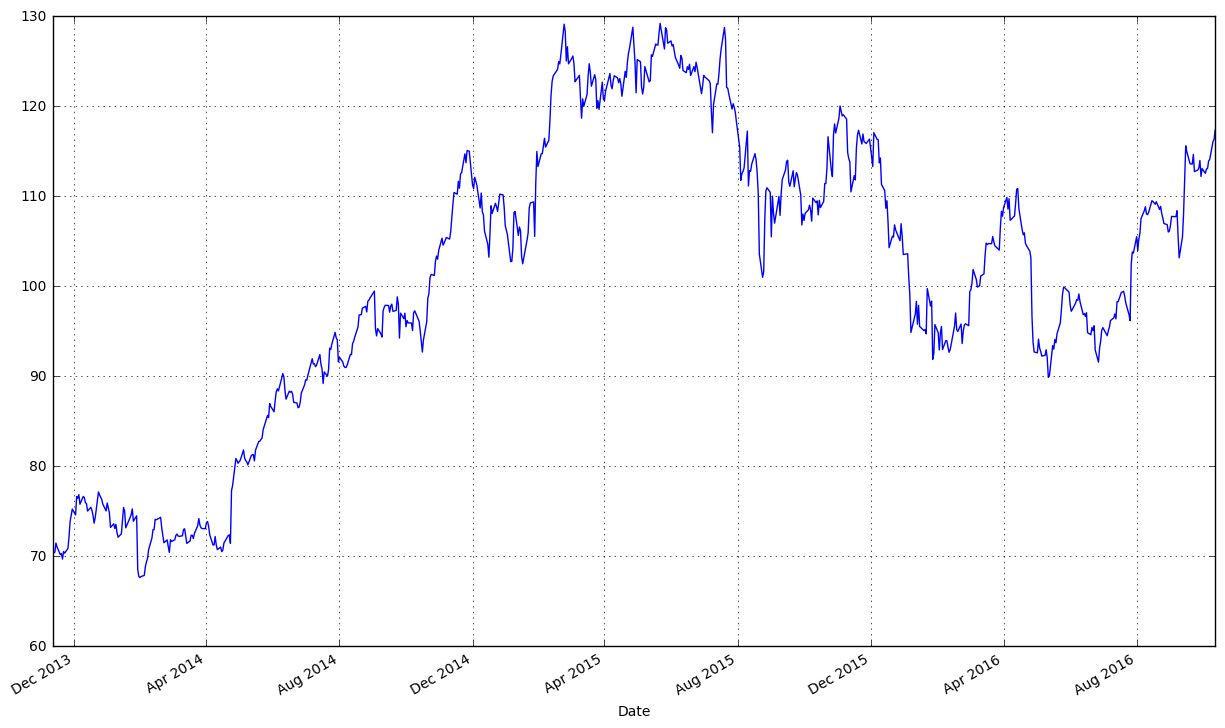

In [190]:
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

<p> With a linechart we can only look at one metric of the stock, it would be better if we could find a way to visualize more of the variables, such as high, low, open, and close...<br> To do this, we can use what is called a Japanese candlestick plot, which is commonly used to represent financial data. </p>

In [191]:
#I didn't write this

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

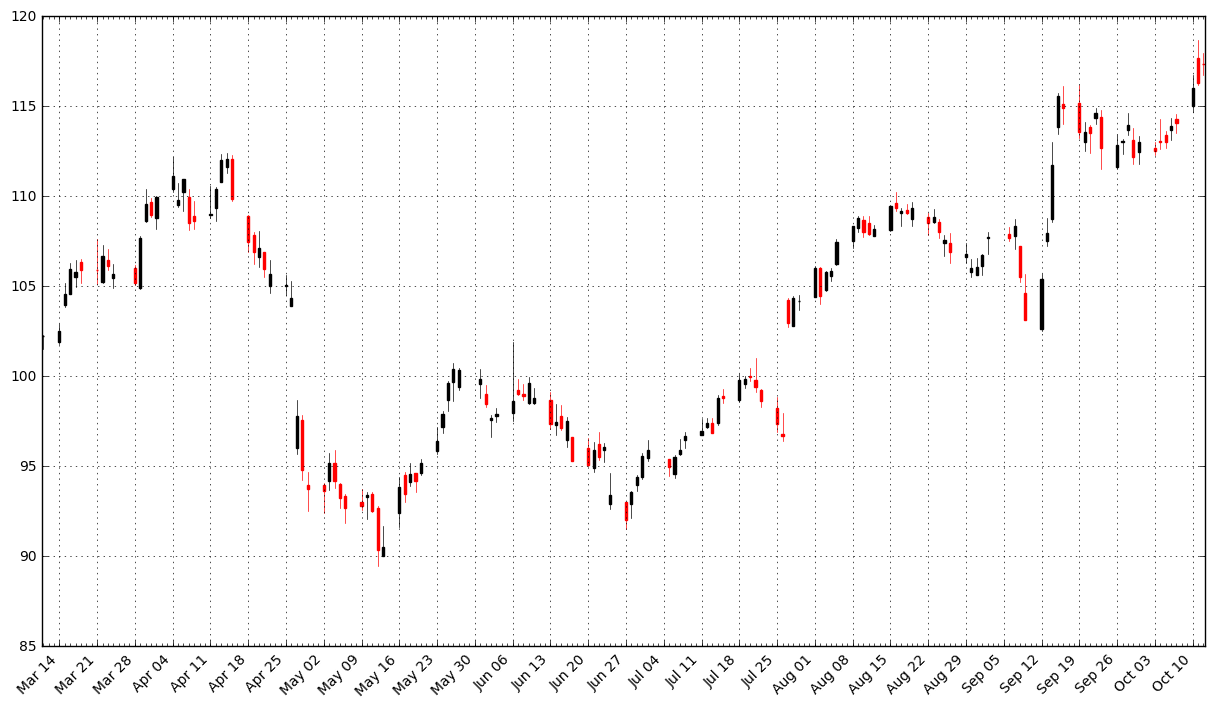

In [192]:
pandas_candlestick_ohlc(apple[0:150])

<p> Black candlestick = gain (closing price > opening price) <br>
Red candlestick = loss (closing price < opening price) <br>
Ends of the wicks = high/low <br>
Ends of the body = open/close </p>

<p> The steep drop off towards the end of April was due to the releasing of Apple's quartly financial reports, which showed siginficant revenue declines. <br>
The jump in price in early September is correlated with the release of several positive reviews for their new iPhone 7.</p>

In [195]:
#getting a few more tech companies in the mix
microsoft = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=MSFT&a=10&b=11&c=2013&d=10&e=11&f=2016&g=d&ignore=.csv")
google = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=GOOG&a=10&b=10&c=2013&d=10&e=11&f=2016&g=d&ignore=.csv")
 
# DF of just the adj closing price of the stocks
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})

stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-10-12,117.339996,786.140015,57.110001
2016-10-11,116.300003,783.070007,57.189999
2016-10-10,116.050003,785.940002,58.040001
2016-10-07,114.059998,775.080017,57.799999
2016-10-06,113.889999,776.859985,57.740002


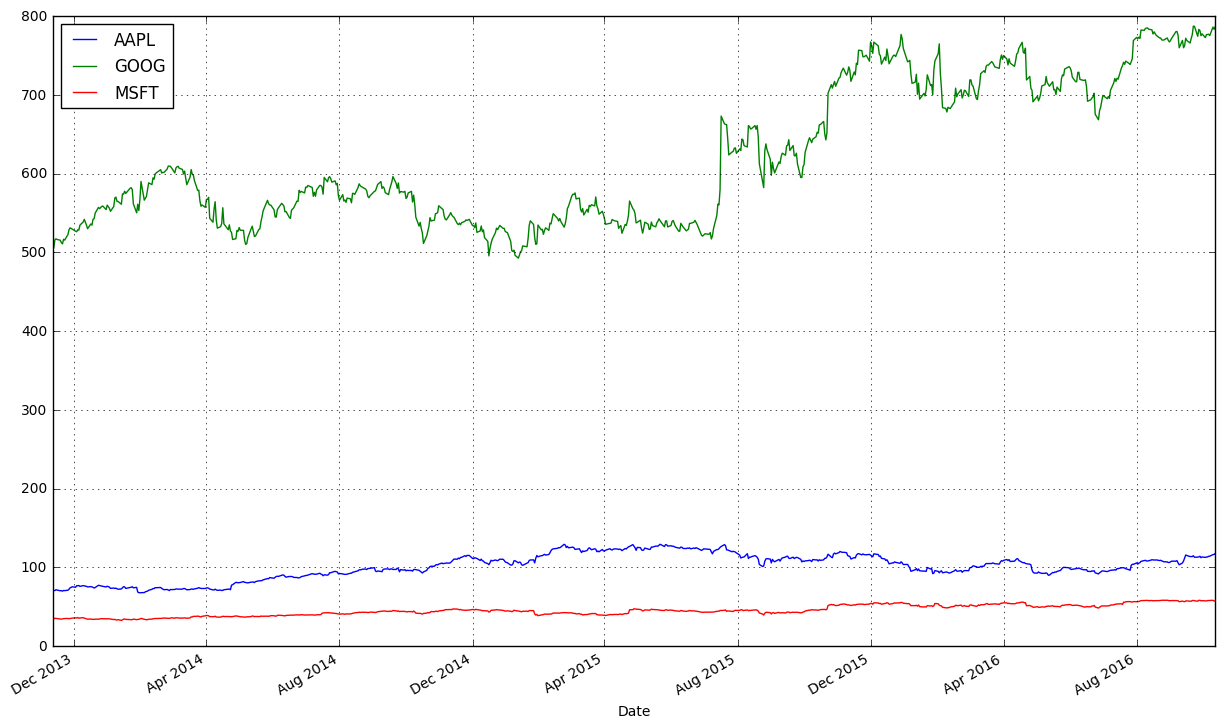

In [196]:
stocks.plot(grid = True)

<p> It's difficult to really get anything out of this graph because the price of the Google stock is dwarfing the price of Apple's and Microsoft's, which makes them appear to not have much of a change over time. We're more interested in the relative change of the stocks rather than their price, so let's create a graph that better shows this. </p>

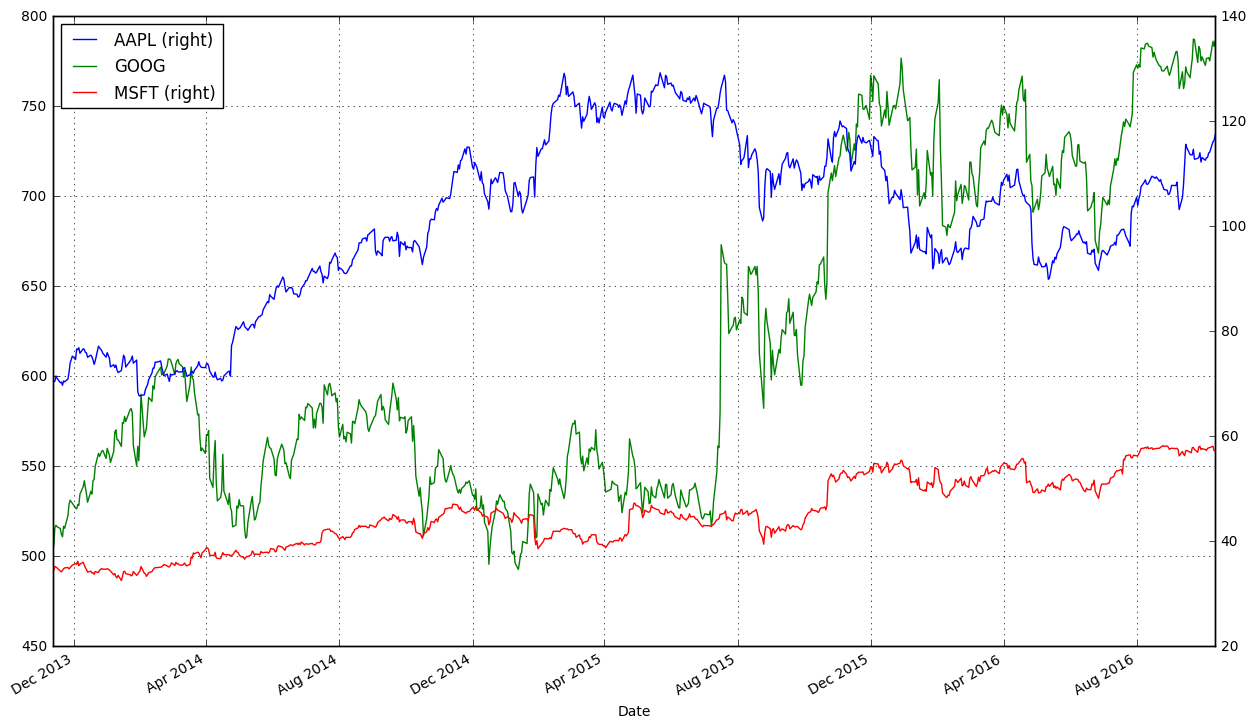

In [197]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [198]:
#Simple return on investment calculation
ROI = (sum(stocks.iloc[-1]) / sum(stocks.iloc[0])) / 3
print(ROI)

#avg ROI = 21.16% ~ so if you had invested $100,000 in these 3 stocks back on 11/11/2013 
#you would have $177,837.92 (not including dividend payments), assuming you reinvested your gains every year

0.21155031088


In [199]:
#pulling the same data for a smaller range of dates to do some analysis on
apple2 = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=AAPL&a=11&b=11&c=2015&d=10&e=11&f=2016&g=d&ignore=.csv")
microsoft2 = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=MSFT&a=11&b=11&c=2015&d=10&e=11&f=2016&g=d&ignore=.csv")
google2 = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=GOOG&a=11&b=11&c=2015&d=10&e=11&f=2016&g=d&ignore=.csv")

stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft2["Adj Close"],
                      "GOOG": google2["Adj Close"]})
 
stocks2.head()

,AAPL,GOOG,MSFT
Date,,,
2016-10-12,117.339996,786.140015,57.110001
2016-10-11,116.300003,783.070007,57.189999
2016-10-10,116.050003,785.940002,58.040001
2016-10-07,114.059998,775.080017,57.799999
2016-10-06,113.889999,776.859985,57.740002


In [200]:
#Calculating the stocks return since the beginning of the period
stock_return = stocks2.apply(lambda x: x / x[-1])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2016-10-12,1.054409,1.063976,1.078124
2016-10-11,1.045064,1.059821,1.079634
2016-10-10,1.042817,1.063705,1.095680
2016-10-07,1.024935,1.049007,1.091150
2016-10-06,1.023408,1.051416,1.090017


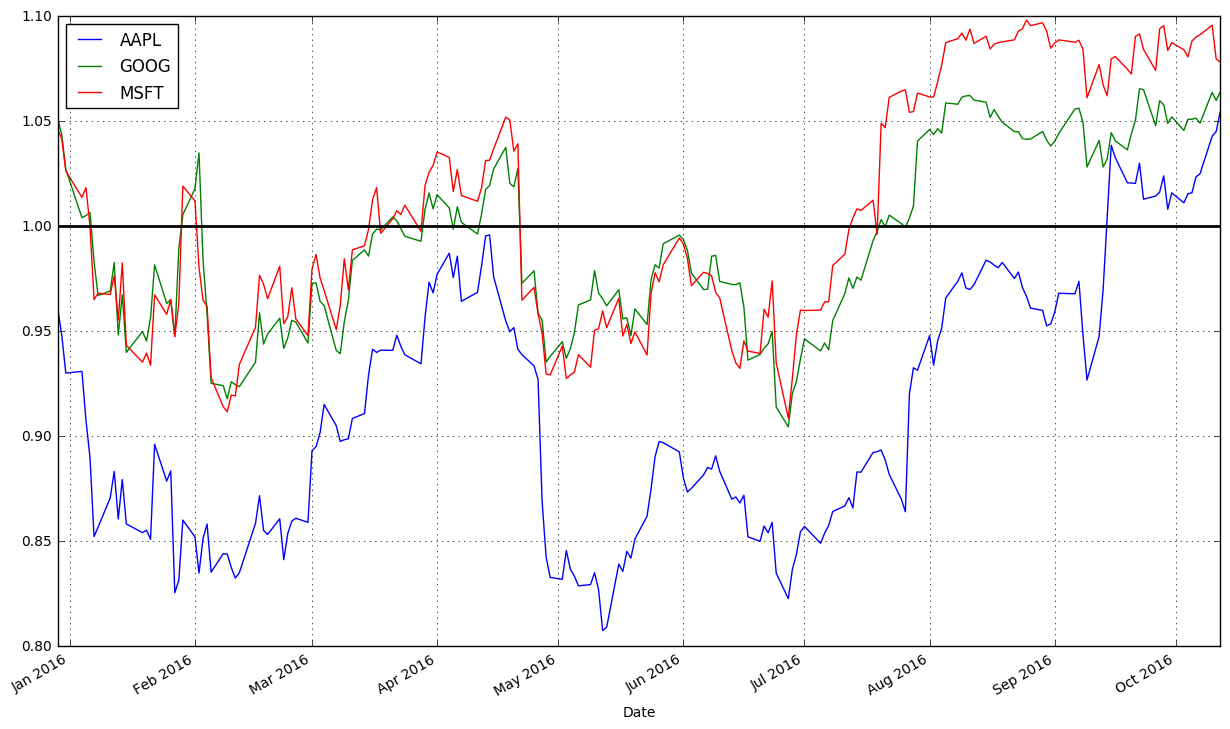

In [201]:
stock_return.iloc[0:200].plot(grid = True).axhline(y = 1, color = "black", lw = 2)

<p> This chart shows how profitable each stock has been since the beginning of the period (12/11/2015)<br>
It also shows that these three stocks are highly correlated because their prices rise and fall in similar patterns</p>

<h1>FIN</h1>